In [1]:
# import necessary libraries
import pdb
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage import exposure
import cv2
import warnings
warnings.filterwarnings('ignore')
import shutil
import tensorflow as tf
%matplotlib inline
import matplotlib.pylab as pylab
import seaborn as sns
import pprint
import PIL
from PIL import Image
import glob
import os
#from colorama import Fore, Back, Style
viz_counter=0
# to check gpu device is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
FIND_FOLDER = '/kaggle/input/custom/data/trainimages' # replace this with your dataset directory
images_files = glob.glob(os.path.join(FIND_FOLDER, '*.png'))
print(len(images_files), "Files Found.")

320 Files Found.


In [3]:
import pdb
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
# use this seed function to make sure the result is reproducible
def reset_seed():
  torch.manual_seed(42)
  random.seed(42)
  torch.cuda.manual_seed(42)
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import torchvision
from torch.utils.data import DataLoader
from PIL import Image
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2

class QU_Dataset(Dataset):
  def __init__(self, image_dir, mask_dir, transform=None, state=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img_path = os.path.join(self.image_dir, self.images[index])
    mask_path = os.path.join(self.mask_dir, self.images[index]).replace(".png",".png")
    image = np.array(Image.open(img_path).convert("RGB"))
    NEW_IMAGE_HEIGHT = 224
    NEW_IMAGE_WIDTH = 224
    image = cv2.resize(image, (NEW_IMAGE_WIDTH, NEW_IMAGE_HEIGHT))

    mask = np.array(Image.open(mask_path))
    mask[mask >= 1] = 1.0

    if self.transform is not None:
      augmentations = self.transform(image=image, mask=mask)
      image = augmentations["image"]
      mask = augmentations["mask"]
    return image, mask

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

train_transform = A.Compose(
    [
        #A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean = [0.0, 0.0, 0.0],
            std = [1.0, 1.0, 1.0],
            max_pixel_value = 255.0
        ),
        ToTensorV2(),
    ])
val_transform = A.Compose(
    [
        #A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean = [0.0, 0.0, 0.0],
            std = [1.0, 1.0, 1.0],
            max_pixel_value = 255.0
        ),
        ToTensorV2(),
    ])

TRAIN_DIR = '/kaggle/input/custom/data/trainimages'
TRAIN_MASK = '/kaggle/input/custom/data/trainmasks'
TEST_DIR = '/kaggle/input/custom/data/valimages'
TEST_MASK = '/kaggle/input/custom/data/valmasks'

train_ds1 = QU_Dataset(TRAIN_DIR, TRAIN_MASK, transform=train_transform)
#train_ds, val_ds = torch.utils.data.random_split(train_ds1,[55,5], generator=torch.Generator().manual_seed(42))
test_ds = QU_Dataset(TEST_DIR, TEST_MASK, transform=val_transform)
reset_seed()
BATCH_SIZE = 4
NUM_WORKERS = 0
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
PIN_MEMORY = True
train_loader = DataLoader(
    train_ds1,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    pin_memory = PIN_MEMORY,
    shuffle=True,
)
# val_loader = DataLoader(
#     val_ds,
#     batch_size=BATCH_SIZE,
#     num_workers = NUM_WORKERS,
#     pin_memory = PIN_MEMORY,
#     shuffle=False
# )
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    num_workers = NUM_WORKERS,
    pin_memory = PIN_MEMORY,
    shuffle=False
)


In [4]:
for X, y in train_ds1:
  print(X.shape)
  print(y.shape)
  break

torch.Size([3, 224, 224])
torch.Size([224, 224])


In [5]:
def conv1x1(in_planes, out_planes, stride=1):
  return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class qkv_transform(nn.Conv1d):
  """Conv1d for qkv_transform"""
# define Medical Transformer architecture
class AxialAttention(nn.Module):

  def __init__(self,
               in_planes,
               out_planes,
               groups=8,
               kernel_size=56,
               stride=1,
               bias=False,
               width=False):
    """
    args :
      in_planes : d_q
      out_planes : d_out
      groups : number heads
      kernel_size : size of memory block
    """
    super().__init__()
    self.in_planes = in_planes
    self.out_planes = out_planes
    self.groups = groups
    self.group_planes = out_planes // groups
    self.kernel_size = kernel_size
    self.stride = stride
    self.bias = bias
    self.width = width

    # Multi-head self attention
    # d_q = out_planes // 2, d_out = out_planes (out_planes = 16) => number of
    self.qkv_transform = qkv_transform(in_planes, out_planes*2, kernel_size=1, stride=1,
                                       padding=0, bias=False)
    self.bn_qkv = nn.BatchNorm1d(out_planes * 2) # shape : q,k : (out_planes, d_q)
    self.bn_similarity = nn.BatchNorm2d(groups * 3)
    self.bn_output = nn.BatchNorm1d(out_planes * 2)

    # position embedding
    # (2 * kernel_size - 1) position : -(kernel_size-1),...,0,...,(kernel_size-1)
    # number of channels = channels of r_q + channels of r_k + channels of r_v
    # group_planes * 2   =  group_planes//2 * 2 + group_planes (dim value + dim query + dim key)
    # => dim of embedding position : group_planes * 2 * (kernel_size * 2 - 1)
    self.relative = nn.Parameter(torch.randn(self.group_planes * 2, kernel_size * 2 - 1), requires_grad=True)
    query_index = torch.arange(kernel_size).unsqueeze(0)
    key_index = torch.arange(kernel_size).unsqueeze(1)
    relative_index = key_index - query_index + kernel_size - 1
    self.register_buffer('flatten_index', relative_index.view(-1))
    if stride > 1:
      self.pooling = nn.AvgPool2d(stride, stride=stride)

    self.reset_paremeters()

  def forward(self, x):
    # axial attention width-axis
    if self.width:
      x = x.permute(0, 2, 1, 3) # N, H, C, W
    else:
      x = x.permute(0, 3, 1, 2) # N, W, C, H
    N, W, C, H = x.shape
    x = x.contiguous().view(N*W, C, H)
    # Transformations
    qkv = self.bn_qkv(self.qkv_transform(x))
    #print(x.shape)
    #print(self.qkv_transform(x).shape)
    q, k, v = torch.split(qkv.reshape(N*W, self.groups, self.group_planes * 2, H),
                          [self.group_planes // 2, self.group_planes // 2, self.group_planes], dim=2)

    # Calculate position embedding
    # self.flatten_index : shape (kernel_size * kernel_size)
    all_embedding = torch.index_select(self.relative, 1, self.flatten_index).view(self.group_planes * 2, self.kernel_size, self.kernel_size)
    q_embedding, k_embedding, v_embedding = torch.split(all_embedding, [self.group_planes // 2, self.group_planes // 2, self.group_planes], dim=0)
    qqn = q_embedding[0].detach().cpu().numpy()
    #plt.imshow(qqn)
    kqn = k_embedding[0].detach().cpu().numpy()
    #plt.imshow(kqn)
    # q : shape (N*W, number heads, self.group_planes // 2 = d_q, H)
    # k : shape (N*W, number heads, self.group_planes // 2 = d_q, H)
    # v : shape (N*W, number heads, self.group_planes = 2 * d_q, H)
    # q_embedding : shape (self.group_planes // 2, kernel_size, kernel_size)
    # k_embedding : shape (self.group_planes // 2, kernel_size, kernel_size)
    # v_embedding : shape (self.group_planes, kernel_size, kernel_size)
    # qr : shape (N*W, number heads, kernel_size, kernel_size)
    # kr : shape (N*W, number heads, kernel_size, kernel_size)
    # why transpose(2, 3) -> because index of equal (2) Medical-Transform
    # qk : shape
    qr = torch.einsum('bgci,cij->bgij', q, q_embedding)
    kr = torch.einsum('bgci,cij->bgij', k, k_embedding).transpose(2, 3)
    qk = torch.einsum('bgci,bgcj->bgij', q, k)
    # batchnorm each qr, qk, kr before sum
    stacked_similarity = torch.cat([qk, qr, kr], dim=1)
    stacked_similarity = self.bn_similarity(stacked_similarity).view(N*W, 3, self.groups, H, H).sum(dim=1)
    # stacked_similarity = self.bn_qr(qr) + self.bn_kr(kr) + self.bn_qk(qk)
    # (N*W, groups, H, H)
    similarity = F.softmax(stacked_similarity, dim=3)
    sv = torch.einsum('bgij,bgcj->bgci', similarity, v)
    sve = torch.einsum('bgij,cij->bgci', similarity, v_embedding)
    stacked_output = torch.cat([sv, sve], dim=-1).view(N*W, self.out_planes*2, H)
    output = self.bn_output(stacked_output).view(N, W, self.out_planes, 2, H).sum(dim=-2)

    if self.width:
      output = output.permute(0, 2, 1, 3)
    else:
      output = output.permute(0, 2, 3, 1)

    if self.stride > 1:
      output = self.pooling(output)
    return output

  def reset_paremeters(self):
    self.qkv_transform.weight.data.normal_(0, math.sqrt(1. / self.in_planes))
    nn.init.normal_(self.relative, 0, math.sqrt(1. / self.group_planes))
# check this code to make sure the output shape is correct
"""
x_test : shape
"""
x_test = torch.randn(1, 256, 9, 9)
gate = AxialAttention(in_planes=256,out_planes= 256,groups = 8,kernel_size= 9)
b = gate(x_test)
print(x_test.shape)
print(b.shape)
kernel_size = 5
que_index = torch.arange(5).unsqueeze(0)
key_index = torch.arange(5).unsqueeze(1)
a = key_index - que_index + kernel_size - 1
print(a)
b = a.view(-1)
a = torch.randn(4, kernel_size * 2 - 1)
print(f'a:{a}')
print(a.shape)
print(f'b:{b}')
c = torch.index_select(a, 1, b).reshape(4, kernel_size, kernel_size)
"""
q, k, v = torch.split(c, [1, 1, 2], dim=0)
print(q, q.shape)
print(k, k.shape)
print(v, v.shape)
"""
c.shape

torch.Size([1, 256, 9, 9])
torch.Size([1, 256, 9, 9])
tensor([[4, 3, 2, 1, 0],
        [5, 4, 3, 2, 1],
        [6, 5, 4, 3, 2],
        [7, 6, 5, 4, 3],
        [8, 7, 6, 5, 4]])
a:tensor([[-0.3927,  0.2517,  1.4877, -0.4631, -1.0468,  1.8816, -0.1268,  1.9026,
         -1.2905],
        [-0.2800,  0.6117,  0.4961, -0.2166, -0.8644,  0.2344, -1.3138,  1.7738,
          1.1965],
        [-0.0136,  1.3046, -2.2844,  1.4070, -0.1787,  0.2277, -1.5650,  1.1589,
          0.0232],
        [ 0.0426, -0.0195, -0.3383, -1.6627,  0.9750,  0.0910, -0.2920, -0.0769,
          1.2092]])
torch.Size([4, 9])
b:tensor([4, 3, 2, 1, 0, 5, 4, 3, 2, 1, 6, 5, 4, 3, 2, 7, 6, 5, 4, 3, 8, 7, 6, 5,
        4])


torch.Size([4, 5, 5])

In [6]:
class AxialAttention_dynamic(nn.Module):
  def __init__(self,
               in_planes,
               out_planes,
               groups=8,
               kernel_size=56,
               stride=1,
               bias=False,
               width=False):
      assert (in_planes % groups == 0) and (out_planes % groups == 0)
      super(AxialAttention_dynamic, self).__init__()
      self.in_planes = in_planes
      self.out_planes = out_planes
      self.groups = groups
      self.group_planes = out_planes // groups
      self.kernel_size = kernel_size
      self.stride = stride
      self.bias = bias
      self.width = width

      # Multi-head self attention
      self.qkv_transform = qkv_transform(in_planes, out_planes * 2, kernel_size=1, stride=1,
                                          padding=0, bias=False)
      self.bn_qkv = nn.BatchNorm1d(out_planes * 2)
      self.bn_similarity = nn.BatchNorm2d(groups * 3)
      self.bn_output = nn.BatchNorm1d(out_planes * 2)

      # Priority on encoding

      ## Initial values

      self.f_qr = nn.Parameter(torch.tensor(0.1),  requires_grad=False)
      self.f_kr = nn.Parameter(torch.tensor(0.1),  requires_grad=False)
      self.f_sve = nn.Parameter(torch.tensor(0.1),  requires_grad=False)
      self.f_sv = nn.Parameter(torch.tensor(1.0),  requires_grad=False)


      # Position embedding
      self.relative = nn.Parameter(torch.randn(self.group_planes * 2, kernel_size * 2 - 1), requires_grad=True)
      query_index = torch.arange(kernel_size).unsqueeze(0)
      key_index = torch.arange(kernel_size).unsqueeze(1)
      relative_index = key_index - query_index + kernel_size - 1
      self.register_buffer('flatten_index', relative_index.view(-1))
      if stride > 1:
          self.pooling = nn.AvgPool2d(stride, stride=stride)

      self.reset_parameters()
      # self.print_para()

  def forward(self, x):
      if self.width:
          x = x.permute(0, 2, 1, 3)
      else:
          x = x.permute(0, 3, 1, 2)  # N, W, C, H
      N, W, C, H = x.shape
      x = x.contiguous().view(N * W, C, H)

      # Transformations
      qkv = self.bn_qkv(self.qkv_transform(x))
      q, k, v = torch.split(qkv.reshape(N * W, self.groups, self.group_planes * 2, H), [self.group_planes // 2, self.group_planes // 2, self.group_planes], dim=2)

      # Calculate position embedding
      all_embeddings = torch.index_select(self.relative, 1, self.flatten_index).view(self.group_planes * 2, self.kernel_size, self.kernel_size)
      q_embedding, k_embedding, v_embedding = torch.split(all_embeddings, [self.group_planes // 2, self.group_planes // 2, self.group_planes], dim=0)
      qr = torch.einsum('bgci,cij->bgij', q, q_embedding)
      kr = torch.einsum('bgci,cij->bgij', k, k_embedding).transpose(2, 3)
      qk = torch.einsum('bgci, bgcj->bgij', q, k)


      # multiply by factors
      qr = torch.mul(qr, self.f_qr)
      kr = torch.mul(kr, self.f_kr)

      stacked_similarity = torch.cat([qk, qr, kr], dim=1)
      stacked_similarity = self.bn_similarity(stacked_similarity).view(N * W, 3, self.groups, H, H).sum(dim=1)
      #stacked_similarity = self.bn_qr(qr) + self.bn_kr(kr) + self.bn_qk(qk)
      # (N, groups, H, H, W)
      similarity = F.softmax(stacked_similarity, dim=3)
      sv = torch.einsum('bgij,bgcj->bgci', similarity, v)
      sve = torch.einsum('bgij,cij->bgci', similarity, v_embedding)

      # multiply by factors
      sv = torch.mul(sv, self.f_sv)
      sve = torch.mul(sve, self.f_sve)

      stacked_output = torch.cat([sv, sve], dim=-1).view(N * W, self.out_planes * 2, H)
      output = self.bn_output(stacked_output).view(N, W, self.out_planes, 2, H).sum(dim=-2)

      if self.width:
          output = output.permute(0, 2, 1, 3)
      else:
          output = output.permute(0, 2, 3, 1)

      if self.stride > 1:
          output = self.pooling(output)

      return output
  def reset_parameters(self):
      self.qkv_transform.weight.data.normal_(0, math.sqrt(1. / self.in_planes))
      #nn.init.uniform_(self.relative, -0.1, 0.1)
      nn.init.normal_(self.relative, 0., math.sqrt(1. / self.group_planes))
class AxialAttention_wopos(nn.Module):
  def __init__(self, in_planes, out_planes, groups=8, kernel_size=56,
                stride=1, bias=False, width=False):
      assert (in_planes % groups == 0) and (out_planes % groups == 0)
      super(AxialAttention_wopos, self).__init__()
      self.in_planes = in_planes
      self.out_planes = out_planes
      self.groups = groups
      self.group_planes = out_planes // groups
      self.kernel_size = kernel_size
      self.stride = stride
      self.bias = bias
      self.width = width

      # Multi-head self attention
      self.qkv_transform = qkv_transform(in_planes, out_planes * 2, kernel_size=1, stride=1,
                                          padding=0, bias=False)
      self.bn_qkv = nn.BatchNorm1d(out_planes * 2)
      self.bn_similarity = nn.BatchNorm2d(groups )

      self.bn_output = nn.BatchNorm1d(out_planes * 1)

      if stride > 1:
          self.pooling = nn.AvgPool2d(stride, stride=stride)

      self.reset_parameters()

  def forward(self, x):
      if self.width:
          x = x.permute(0, 2, 1, 3)
      else:
          x = x.permute(0, 3, 1, 2)  # N, W, C, H
      N, W, C, H = x.shape
      x = x.contiguous().view(N * W, C, H)

      # Transformations
      qkv = self.bn_qkv(self.qkv_transform(x))
      q, k, v = torch.split(qkv.reshape(N * W, self.groups, self.group_planes * 2, H), [self.group_planes // 2, self.group_planes // 2, self.group_planes], dim=2)

      qk = torch.einsum('bgci, bgcj->bgij', q, k)

      stacked_similarity = self.bn_similarity(qk).reshape(N * W, 1, self.groups, H, H).sum(dim=1).contiguous()

      similarity = F.softmax(stacked_similarity, dim=3)
      sv = torch.einsum('bgij,bgcj->bgci', similarity, v)

      sv = sv.reshape(N*W,self.out_planes * 1, H).contiguous()
      output = self.bn_output(sv).reshape(N, W, self.out_planes, 1, H).sum(dim=-2).contiguous()


      if self.width:
          output = output.permute(0, 2, 1, 3)
      else:
          output = output.permute(0, 2, 3, 1)

      if self.stride > 1:
          output = self.pooling(output)

      return output

  def reset_parameters(self):
      self.qkv_transform.weight.data.normal_(0, math.sqrt(1. / self.in_planes))
      #nn.init.uniform_(self.relative, -0.1, 0.1)
      # nn.init.normal_(self.relative, 0., math.sqrt(1. / self.group_planes))
class AxialBlock(nn.Module):
  expansion = 2

  def __init__(self,
               inplanes,
               planes,
               stride=1,
               downsample=None,
               groups=1,
               base_width=64,
               dilation=1,
               norm_layer=None,
               kernel_size=56):
    super().__init__()
    if norm_layer is None:
      norm_layer = nn.BatchNorm2d
    width = int(planes * (base_width / 64.))
    # Both self.conv2 and self.downsample layers downsample the input when stride != 1
    self.groups = groups
    self.conv_down = conv1x1(inplanes, width)
    self.bn1 = norm_layer(width)
    self.hight_block = AxialAttention(width, width, groups=groups, kernel_size=kernel_size)
    self.width_block = AxialAttention(width, width, groups=groups, kernel_size=kernel_size, width=True)
    self.conv_up = conv1x1(width, planes*self.expansion)
    self.bn2 = norm_layer(planes * self.expansion)
    self.relu = nn.ReLU(inplace=True)
    self.downsample = downsample
    self.stride = stride

  def forward(self, x):
    identity = x

    out = self.conv_down(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.hight_block(out)
    out = self.width_block(out)
    out = self.relu(out)

    out = self.conv_up(out)
    out = self.bn2(out)

    if self.downsample is not None:
      identity = self.downsample(x)

    out += identity
    out = self.relu(out)

    return out
class AxialBlock_dynamic(nn.Module):
  expansion = 2

  def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                base_width=64, dilation=1, norm_layer=None, kernel_size=56):
      super(AxialBlock_dynamic, self).__init__()
      if norm_layer is None:
          norm_layer = nn.BatchNorm2d
      width = int(planes * (base_width / 64.))
      # Both self.conv2 and self.downsample layers downsample the input when stride != 1
      self.conv_down = conv1x1(inplanes, width)
      self.bn1 = norm_layer(width)
      self.hight_block = AxialAttention_dynamic(width, width, groups=groups, kernel_size=kernel_size)
      self.width_block = AxialAttention_dynamic(width, width, groups=groups, kernel_size=kernel_size, stride=stride, width=True)
      self.conv_up = conv1x1(width, planes * self.expansion)
      self.bn2 = norm_layer(planes * self.expansion)
      self.relu = nn.ReLU(inplace=True)
      self.downsample = downsample
      self.stride = stride

  def forward(self, x):
      identity = x

      out = self.conv_down(x)
      out = self.bn1(out)
      out = self.relu(out)

      out = self.hight_block(out)
      out = self.width_block(out)
      out = self.relu(out)

      out = self.conv_up(out)
      out = self.bn2(out)

      if self.downsample is not None:
          identity = self.downsample(x)
      #print(out.shape)
      #print(identity.shape)
      out += identity
      out = self.relu(out)

      return out
class AxialBlock_wopos(nn.Module):
  expansion = 2

  def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                base_width=64, dilation=1, norm_layer=None, kernel_size=56):
      super(AxialBlock_wopos, self).__init__()
      if norm_layer is None:
          norm_layer = nn.BatchNorm2d
      # print(kernel_size)
      width = int(planes * (base_width / 64.))
      # Both self.conv2 and self.downsample layers downsample the input when stride != 1
      self.conv_down = conv1x1(inplanes, width)
      self.conv1 = nn.Conv2d(width, width, kernel_size = 1)
      self.bn1 = norm_layer(width)
      self.hight_block = AxialAttention_wopos(width, width, groups=groups, kernel_size=kernel_size)
      self.width_block = AxialAttention_wopos(width, width, groups=groups, kernel_size=kernel_size, stride=stride, width=True)
      self.conv_up = conv1x1(width, planes * self.expansion)
      self.bn2 = norm_layer(planes * self.expansion)
      self.relu = nn.ReLU(inplace=True)
      self.downsample = downsample
      self.stride = stride

  def forward(self, x):
      identity = x

      # pdb.set_trace()

      out = self.conv_down(x)
      out = self.bn1(out)
      out = self.relu(out)
      # print(out.shape)
      out = self.hight_block(out)
      out = self.width_block(out)

      out = self.relu(out)

      out = self.conv_up(out)
      out = self.bn2(out)

      if self.downsample is not None:
          identity = self.downsample(x)

      out += identity
      out = self.relu(out)

      return out
class ResAxialAttentionUNet(nn.Module):

  def __init__(self, block, layers, num_classes=2, zero_init_residual=True,
                groups=8, width_per_group=64, replace_stride_with_dilation=None,
                norm_layer=None, s=0.125, img_size = 128,imgchan = 3):
      super(ResAxialAttentionUNet, self).__init__()
      if norm_layer is None:
          norm_layer = nn.BatchNorm2d
      self._norm_layer = norm_layer

      self.inplanes = int(64 * s)
      self.dilation = 1
      if replace_stride_with_dilation is None:
          replace_stride_with_dilation = [False, False, False]
      if len(replace_stride_with_dilation) != 3:
          raise ValueError("replace_stride_with_dilation should be None "
                            "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
      self.groups = groups
      self.base_width = width_per_group
      self.conv1 = nn.Conv2d(imgchan, self.inplanes, kernel_size=7, stride=2, padding=3,
                              bias=False)
      self.conv2 = nn.Conv2d(self.inplanes, 128, kernel_size=3, stride=1, padding=1, bias=False)
      self.conv3 = nn.Conv2d(128, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
      self.bn1 = norm_layer(self.inplanes)
      self.bn2 = norm_layer(128)
      self.bn3 = norm_layer(self.inplanes)
      self.relu = nn.ReLU(inplace=True)
      # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      self.layer1 = self._make_layer(block, int(128 * s), layers[0], kernel_size= (img_size//2))
      self.layer2 = self._make_layer(block, int(256 * s), layers[1], stride=2, kernel_size=(img_size//2),
                                      dilate=replace_stride_with_dilation[0])
      self.layer3 = self._make_layer(block, int(512 * s), layers[2], stride=2, kernel_size=(img_size//4),
                                      dilate=replace_stride_with_dilation[1])
      self.layer4 = self._make_layer(block, int(1024 * s), layers[3], stride=2, kernel_size=(img_size//8),
                                      dilate=replace_stride_with_dilation[2])

      # Decoder
      self.decoder1 = nn.Conv2d(int(1024 *2*s)      ,        int(1024*2*s), kernel_size=3, stride=2, padding=1)
      self.decoder2 = nn.Conv2d(int(1024  *2*s)     , int(1024*s), kernel_size=3, stride=1, padding=1)
      self.decoder3 = nn.Conv2d(int(1024*s),  int(512*s), kernel_size=3, stride=1, padding=1)
      self.decoder4 = nn.Conv2d(int(512*s) ,  int(256*s), kernel_size=3, stride=1, padding=1)
      self.decoder5 = nn.Conv2d(int(256*s) , int(128*s) , kernel_size=3, stride=1, padding=1)
      self.adjust   = nn.Conv2d(int(128*s) , num_classes, kernel_size=1, stride=1, padding=0)
      self.soft     = nn.Softmax(dim=1)


  def _make_layer(self, block, planes, blocks, kernel_size=56, stride=1, dilate=False):
      norm_layer = self._norm_layer
      downsample = None
      previous_dilation = self.dilation
      if dilate:
          self.dilation *= stride
          stride = 1
      if stride != 1 or self.inplanes != planes * block.expansion:
          downsample = nn.Sequential(
              conv1x1(self.inplanes, planes * block.expansion, stride),
              norm_layer(planes * block.expansion),
          )

      layers = []
      layers.append(block(self.inplanes, planes, stride, downsample, groups=self.groups,
                          base_width=self.base_width, dilation=previous_dilation,
                          norm_layer=norm_layer, kernel_size=kernel_size))
      self.inplanes = planes * block.expansion
      if stride != 1:
          kernel_size = kernel_size // 2

      for _ in range(1, blocks):
          layers.append(block(self.inplanes, planes, groups=self.groups,
                              base_width=self.base_width, dilation=self.dilation,
                              norm_layer=norm_layer, kernel_size=kernel_size))

      return nn.Sequential(*layers)

  def _forward_impl(self, x):

      # AxialAttention Encoder
      # pdb.set_trace()
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.bn2(x)
      x = self.relu(x)
      x = self.conv3(x)
      x = self.bn3(x)
      x = self.relu(x)
      #print(x.shape)
      x1 = self.layer1(x)
      #print(x.shape)
      x2 = self.layer2(x1)
      # print(x2.shape)
      x3 = self.layer3(x2)
      # print(x3.shape)
      x4 = self.layer4(x3)

      x = F.relu(F.interpolate(self.decoder1(x4), scale_factor=(2,2), mode ='bilinear'))
      x = torch.add(x, x4)
      x = F.relu(F.interpolate(self.decoder2(x) , scale_factor=(2,2), mode ='bilinear'))
      x = torch.add(x, x3)
      x = F.relu(F.interpolate(self.decoder3(x) , scale_factor=(2,2), mode ='bilinear'))
      x = torch.add(x, x2)
      x = F.relu(F.interpolate(self.decoder4(x) , scale_factor=(2,2), mode ='bilinear'))
      x = torch.add(x, x1)
      x = F.relu(F.interpolate(self.decoder5(x) , scale_factor=(2,2), mode ='bilinear'))
      x = self.adjust(F.relu(x))
      # pdb.set_trace()
      return x

  def forward(self, x):
      return self._forward_impl(x)
class medt_net(nn.Module):

  def __init__(self, block, block_2, layers, num_classes=2, zero_init_residual=True,
              groups=8, width_per_group=64, replace_stride_with_dilation=None,
              norm_layer=None, s=0.125, img_size = 128,imgchan = 3):
    super(medt_net, self).__init__()
    if norm_layer is None:
        norm_layer = nn.BatchNorm2d
    self._norm_layer = norm_layer

    self.inplanes = int(64 * s)
    self.dilation = 1
    if replace_stride_with_dilation is None:
        replace_stride_with_dilation = [False, False, False]
    if len(replace_stride_with_dilation) != 3:
        raise ValueError("replace_stride_with_dilation should be None "
                          "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
    self.groups = groups
    self.base_width = width_per_group
    self.conv1 = nn.Conv2d(imgchan, self.inplanes, kernel_size=7, stride=2, padding=3,
                            bias=False)
    self.conv2 = nn.Conv2d(self.inplanes, 128, kernel_size=3, stride=1, padding=1, bias=False)
    self.conv3 = nn.Conv2d(128, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = norm_layer(self.inplanes)
    self.bn2 = norm_layer(128)
    self.bn3 = norm_layer(self.inplanes)
    # self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = norm_layer(self.inplanes)
    self.relu = nn.ReLU(inplace=True)
    # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.layer1 = self._make_layer(block, int(128 * s), layers[0], kernel_size= (img_size//2))
    self.layer2 = self._make_layer(block, int(256 * s), layers[1], stride=2, kernel_size=(img_size//2),
                                    dilate=replace_stride_with_dilation[0])
    # self.layer3 = self._make_layer(block, int(512 * s), layers[2], stride=2, kernel_size=(img_size//4),
    #                                dilate=replace_stride_with_dilation[1])
    # self.layer4 = self._make_layer(block, int(1024 * s), layers[3], stride=2, kernel_size=(img_size//8),
    #                                dilate=replace_stride_with_dilation[2])

    # Decoder
    # self.decoder1 = nn.Conv2d(int(1024 *2*s)      ,        int(1024*2*s), kernel_size=3, stride=2, padding=1)
    # self.decoder2 = nn.Conv2d(int(1024  *2*s)     , int(1024*s), kernel_size=3, stride=1, padding=1)
    # self.decoder3 = nn.Conv2d(int(1024*s),  int(512*s), kernel_size=3, stride=1, padding=1)
    self.decoder4 = nn.Conv2d(int(512*s) ,  int(256*s), kernel_size=3, stride=1, padding=1)
    self.decoder5 = nn.Conv2d(int(256*s) , int(128*s) , kernel_size=3, stride=1, padding=1)
    self.adjust   = nn.Conv2d(int(128*s) , num_classes, kernel_size=1, stride=1, padding=0)
    self.soft     = nn.Softmax(dim=1)


    self.conv1_p = nn.Conv2d(imgchan, self.inplanes, kernel_size=7, stride=2, padding=3,
                            bias=False)
    self.conv2_p = nn.Conv2d(self.inplanes,128, kernel_size=3, stride=1, padding=1,
                            bias=False)
    self.conv3_p = nn.Conv2d(128, self.inplanes, kernel_size=3, stride=1, padding=1,
                            bias=False)
    # self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1_p = norm_layer(self.inplanes)
    self.bn2_p = norm_layer(128)
    self.bn3_p = norm_layer(self.inplanes)

    self.relu_p = nn.ReLU(inplace=True)

    img_size_p = img_size // 4

    self.layer1_p = self._make_layer(block_2, int(128 * s), layers[0], kernel_size= (img_size_p//2))
    self.layer2_p = self._make_layer(block_2, int(256 * s), layers[1], stride=2, kernel_size=(img_size_p//2),
                                    dilate=replace_stride_with_dilation[0])
    self.layer3_p = self._make_layer(block_2, int(512 * s), layers[2], stride=2, kernel_size=(img_size_p//4),
                                    dilate=replace_stride_with_dilation[1])
    self.layer4_p = self._make_layer(block_2, int(1024 * s), layers[3], stride=2, kernel_size=(img_size_p//8),
                                    dilate=replace_stride_with_dilation[2])

    # Decoder
    self.decoder1_p = nn.Conv2d(int(1024 *2*s)      ,        int(1024*2*s), kernel_size=3, stride=2, padding=1)
    self.decoder2_p = nn.Conv2d(int(1024  *2*s)     , int(1024*s), kernel_size=3, stride=1, padding=1)
    self.decoder3_p = nn.Conv2d(int(1024*s),  int(512*s), kernel_size=3, stride=1, padding=1)
    self.decoder4_p = nn.Conv2d(int(512*s) ,  int(256*s), kernel_size=3, stride=1, padding=1)
    self.decoder5_p = nn.Conv2d(int(256*s) , int(128*s) , kernel_size=3, stride=1, padding=1)

    self.decoderf = nn.Conv2d(int(128*s) , int(128*s) , kernel_size=3, stride=1, padding=1)
    self.adjust_p   = nn.Conv2d(int(128*s) , num_classes, kernel_size=1, stride=1, padding=0)
    self.soft_p     = nn.Softmax(dim=1)


  def _make_layer(self, block, planes, blocks, kernel_size=56, stride=1, dilate=False):
    norm_layer = self._norm_layer
    downsample = None
    previous_dilation = self.dilation
    if dilate:
        self.dilation *= stride
        stride = 1
    if stride != 1 or self.inplanes != planes * block.expansion:
        downsample = nn.Sequential(
            conv1x1(self.inplanes, planes * block.expansion, stride),
            norm_layer(planes * block.expansion),
        )

    layers = []
    layers.append(block(self.inplanes, planes, stride, downsample, groups=self.groups,
                        base_width=self.base_width, dilation=previous_dilation,
                        norm_layer=norm_layer, kernel_size=kernel_size))
    self.inplanes = planes * block.expansion
    if stride != 1:
        kernel_size = kernel_size // 2

    for _ in range(1, blocks):
        layers.append(block(self.inplanes, planes, groups=self.groups,
                            base_width=self.base_width, dilation=self.dilation,
                            norm_layer=norm_layer, kernel_size=kernel_size))

    return nn.Sequential(*layers)

  def _forward_impl(self, x):

    xin = x.clone()
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.conv3(x)
    x = self.bn3(x)
    # x = F.max_pool2d(x,2,2)
    x = self.relu(x)

    # x = self.maxpool(x)
    # pdb.set_trace()
    x1 = self.layer1(x)
    # print(x1.shape)
    x2 = self.layer2(x1)
    # print(x2.shape)
    # x3 = self.layer3(x2)
    # # print(x3.shape)
    # x4 = self.layer4(x3)
    # # print(x4.shape)
    # x = F.relu(F.interpolate(self.decoder1(x4), scale_factor=(2,2), mode ='bilinear'))
    # x = torch.add(x, x4)
    # x = F.relu(F.interpolate(self.decoder2(x4) , scale_factor=(2,2), mode ='bilinear'))
    # x = torch.add(x, x3)
    # x = F.relu(F.interpolate(self.decoder3(x3) , scale_factor=(2,2), mode ='bilinear'))
    # x = torch.add(x, x2)
    x = F.relu(F.interpolate(self.decoder4(x2) , scale_factor=(2,2), mode ='bilinear'))
    x = torch.add(x, x1)
    x = F.relu(F.interpolate(self.decoder5(x) , scale_factor=(2,2), mode ='bilinear'))
    # print(x.shape)

    # end of full image training

    # y_out = torch.ones((1,2,128,128))
    x_loc = x.clone()
    # x = F.relu(F.interpolate(self.decoder5(x) , scale_factor=(2,2), mode ='bilinear'))
    #start
    for i in range(0,4):
        for j in range(0,4):

            x_p = xin[:,:,32*i:32*(i+1),32*j:32*(j+1)]
            # begin patch wise
            x_p = self.conv1_p(x_p)
            x_p = self.bn1_p(x_p)
            # x = F.max_pool2d(x,2,2)
            x_p = self.relu(x_p)

            x_p = self.conv2_p(x_p)
            x_p = self.bn2_p(x_p)
            # x = F.max_pool2d(x,2,2)
            x_p = self.relu(x_p)
            x_p = self.conv3_p(x_p)
            x_p = self.bn3_p(x_p)
            # x = F.max_pool2d(x,2,2)
            x_p = self.relu(x_p)

            # x = self.maxpool(x)
            # pdb.set_trace()
            x1_p = self.layer1_p(x_p)
            # print(x1.shape)
            x2_p = self.layer2_p(x1_p)
            # print(x2.shape)
            x3_p = self.layer3_p(x2_p)
            # # print(x3.shape)
            x4_p = self.layer4_p(x3_p)

            x_p = F.relu(F.interpolate(self.decoder1_p(x4_p), scale_factor=(2,2), mode ='bilinear'))
            x_p = torch.add(x_p, x4_p)
            x_p = F.relu(F.interpolate(self.decoder2_p(x_p) , scale_factor=(2,2), mode ='bilinear'))
            x_p = torch.add(x_p, x3_p)
            x_p = F.relu(F.interpolate(self.decoder3_p(x_p) , scale_factor=(2,2), mode ='bilinear'))
            x_p = torch.add(x_p, x2_p)
            x_p = F.relu(F.interpolate(self.decoder4_p(x_p) , scale_factor=(2,2), mode ='bilinear'))
            x_p = torch.add(x_p, x1_p)
            x_p = F.relu(F.interpolate(self.decoder5_p(x_p) , scale_factor=(2,2), mode ='bilinear'))

            x_loc[:,:,32*i:32*(i+1),32*j:32*(j+1)] = x_p

    x = torch.add(x,x_loc)
    x = F.relu(self.decoderf(x))

    x = self.adjust(F.relu(x))

    # pdb.set_trace()
    return x

  def forward(self, x):
    return self._forward_impl(x)

In [7]:
def gated(pretrained=False, **kwargs):
  model = ResAxialAttentionUNet(AxialBlock_dynamic, [1, 2, 4, 1], s= 0.125, **kwargs)
  return model
net = gated()
x_test = torch.rand(1, 3, 128, 128)
net(x_test);
def MedT(pretrained=False, **kwargs):
    model = medt_net(AxialBlock_dynamic,AxialBlock_wopos, [1, 2, 4, 1], s= 0.125,  **kwargs)
    return model

def logo(pretrained=False, **kwargs):
    model = medt_net(AxialBlock,AxialBlock, [1, 2, 4, 1], s= 0.125, **kwargs)
    return model

In [8]:
import torch
from torch.nn.functional import cross_entropy
from torch.nn.modules.loss import _WeightedLoss
EPSILON = 1e-32

class LogNLLLoss(_WeightedLoss):
    __constants__ = ['weight', 'reduction', 'ignore_index']

    def __init__(self, weight=None, size_average=None, reduce=None, reduction=None,
                 ignore_index=-100):
        super(LogNLLLoss, self).__init__(weight, size_average, reduce, reduction)
        self.ignore_index = ignore_index

    def forward(self, y_input, y_target):
        # y_input = torch.log(y_input + EPSILON)
        return cross_entropy(y_input, y_target, weight=self.weight,
                             ignore_index=self.ignore_index)


def classwise_iou(output, gt):
    """
    Args:
        output: torch.Tensor of shape (n_batch, n_classes, image.shape)
        gt: torch.LongTensor of shape (n_batch, image.shape)
    """
    #dims = (0, *range(2, len(output.shape)))
    #gt = torch.zeros_like(output).scatter_(1, gt[:, None, :], 1)
    output = torch.argmax(output, dim=1)
    intersection = output*gt
    union = output + gt - intersection
    #classwise_iou = (intersection.sum(dim=dims).float() + EPSILON) / (union.sum(dim=dims) + EPSILON)
    classwise_iou = (intersection.sum().float() + EPSILON) / (union.sum() + EPSILON)
    return classwise_iou


def classwise_f1(output, gt):
    """
    Args:
        output: torch.Tensor of shape (n_batch, n_classes, image.shape)
        gt: torch.LongTensor of shape (n_batch, image.shape)
    """

    epsilon = 1e-20
    n_classes = output.shape[1]

    output = torch.argmax(output, dim=1)
    #print(output)
    true_positives = torch.tensor([((output == i) * (gt == i)).sum() for i in range(n_classes)]).float()
    true_positives = true_positives[1].item()
    selected = ((output == 1)).sum().float()
    relevant = ((gt == 1)).sum().float()
    #selected = torch.tensor([(output == i).sum() for i in range(n_classes)]).float()
    #relevant = torch.tensor([(gt == i).sum() for i in range(n_classes)]).float()
    #print("relevant:",relevant)
    #print("selected:",selected)

    precision = (true_positives + epsilon) / (selected + epsilon)
    recall = (true_positives + epsilon) / (relevant + epsilon)
    #print(precision)
    #print(recall)
    classwise_f1 = 2 * (precision * recall) / (precision + recall)

    return classwise_f1


def make_weighted_metric(classwise_metric):
    """
    Args:
        classwise_metric: classwise metric like classwise_IOU or classwise_F1
    """

    def weighted_metric(output, gt, weights=None):

        # dimensions to sum over
        dims = (0, *range(2, len(output.shape)))

        # default weights
        if weights == None:
            weights = torch.ones(output.shape[1]) / output.shape[1]
        else:
            # creating tensor if needed
            if len(weights) != output.shape[1]:
                raise ValueError("The number of weights must match with the number of classes")
            if not isinstance(weights, torch.Tensor):
                weights = torch.tensor(weights)
            # normalizing weights
            weights /= torch.sum(weights)

        classwise_scores = classwise_metric(output, gt).cpu()

        return classwise_scores

    return weighted_metric

In [9]:
#output, gt = torch.ones(3, 2, 5, 5), torch.ones(3, 5, 5).long()
gt = torch.ones(3, 5, 5).long()
output = torch.stack([torch.zeros(3,5,5), torch.ones(3,5,5)], dim=1)
print(classwise_f1(output, gt))
classwise_iou(output, gt)

tensor(1.)


tensor(1.)

In [10]:
from tqdm import tqdm
# define hyperparameters
lr = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_EPOCHS = 60
IMG_SIZE = 224
IMG_CHANEL = 3
save_freq = 5
# code to save checkpoints
def save_checkpoint(state, filename="medt_weights.pth.tar"):
    print("=>Saving checkpoint")
    torch.save(state, filename)
def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
# instantiate any architecture from above architectures defined
model = MedT(img_size = IMG_SIZE, imgchan = IMG_CHANEL)
model.cuda()
#model.cpu()
criterion = LogNLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()
reset_seed()
# training functions
def train_fn(loader, model, optimizer, loss_fn, scaler):
  train_running_loss = 0
  counter = 0
  loop = tqdm(loader)
  for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(device=DEVICE)
    targets = targets.long().to(DEVICE)

    # forward

    with torch.cuda.amp.autocast():
      prediction = model(data)
      loss = loss_fn(prediction, targets)
    
   
    # backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # update tqdm loop
    loop.set_postfix(loss = loss.item())
    train_running_loss += loss.item()
    counter += 1
  return train_running_loss / counter

def check_accuracy(loader, model, loss_fn, device="cuda"): # device can be cpu or cuda
  my_f1 = 0
  my_iou = 0
  val_running_loss = 0
  with torch.no_grad():
    for X, y in loader:
      batch_size = X.shape[0]
      X = X.to(device)
      y = y.long().to(device)
      preds = model(X)
      loss = loss_fn(preds, y)
      val_running_loss += loss.item()
      tmp = preds.detach().cpu()
      tmp[tmp >= 0.5] = 1
      tmp[tmp < 0.5] = 0
      tmp2 = y.detach().cpu()


      tmp = tmp.to(torch.int32)
      my_f1 += classwise_f1(tmp, tmp2).item()
      my_iou += classwise_iou(tmp, tmp2).item()
  print(f"IoU score: {my_iou/len(loader)}")
  print(f"F1 score: {my_f1/len(loader)} ")
  return val_running_loss


In [11]:
for param in model.parameters():
    param.requires_grad = True

In [12]:
# training code
loss_history = {"train":[], "val":[]}
for epoch in range(1, NUM_EPOCHS):
  model.cuda()
  print(f"============Epoch {epoch} ============ ")
  train_loss = train_fn(train_loader, model, optimizer, criterion, scaler)
  """
  if epoch == 10:
    for param in model.parameters():
      param.requires_grad = True
  """
  if (epoch % save_freq) == 0:
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer" : optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)
    val_loss = check_accuracy(test_loader, model, criterion, DEVICE)
    loss_history["val"].append(val_loss)
    loss_history["train"].append(train_loss)


============Epoch 1 ============ 


100%|██████████| 80/80 [01:16<00:00,  1.05it/s, loss=0.198]


============Epoch 2 ============ 


100%|██████████| 80/80 [01:11<00:00,  1.12it/s, loss=0.124]


============Epoch 3 ============ 


100%|██████████| 80/80 [01:12<00:00,  1.11it/s, loss=0.162] 


============Epoch 4 ============ 


100%|██████████| 80/80 [01:11<00:00,  1.11it/s, loss=0.0836]


============Epoch 5 ============ 


100%|██████████| 80/80 [01:11<00:00,  1.12it/s, loss=0.104] 


=>Saving checkpoint
IoU score: 0.8741222739219665
F1 score: 0.932704958319664 
============Epoch 6 ============ 


100%|██████████| 80/80 [01:11<00:00,  1.12it/s, loss=0.0948]


============Epoch 7 ============ 


100%|██████████| 80/80 [01:11<00:00,  1.12it/s, loss=0.116] 


============Epoch 8 ============ 


100%|██████████| 80/80 [01:11<00:00,  1.13it/s, loss=0.07]  


============Epoch 9 ============ 


100%|██████████| 80/80 [01:11<00:00,  1.13it/s, loss=0.109] 


============Epoch 10 ============ 


100%|██████████| 80/80 [01:11<00:00,  1.12it/s, loss=0.0601]


=>Saving checkpoint
IoU score: 0.8936413675546646
F1 score: 0.9436941534280777 
============Epoch 11 ============ 


100%|██████████| 80/80 [01:10<00:00,  1.13it/s, loss=0.077] 


============Epoch 12 ============ 


100%|██████████| 80/80 [01:11<00:00,  1.13it/s, loss=0.0838]


============Epoch 13 ============ 


100%|██████████| 80/80 [01:11<00:00,  1.13it/s, loss=0.0519]


============Epoch 14 ============ 


100%|██████████| 80/80 [01:10<00:00,  1.13it/s, loss=0.0573]


============Epoch 15 ============ 


100%|██████████| 80/80 [01:10<00:00,  1.14it/s, loss=0.101] 


=>Saving checkpoint
IoU score: 0.9022330164909362
F1 score: 0.9484514594078064 
============Epoch 16 ============ 


100%|██████████| 80/80 [01:11<00:00,  1.13it/s, loss=0.0747]


============Epoch 17 ============ 


100%|██████████| 80/80 [01:10<00:00,  1.14it/s, loss=0.0841]


============Epoch 18 ============ 


100%|██████████| 80/80 [01:10<00:00,  1.13it/s, loss=0.0799]


============Epoch 19 ============ 


100%|██████████| 80/80 [01:13<00:00,  1.09it/s, loss=0.0652]


============Epoch 20 ============ 


100%|██████████| 80/80 [01:12<00:00,  1.10it/s, loss=0.0515]


=>Saving checkpoint
IoU score: 0.9096142917871475
F1 score: 0.9525185018777848 
============Epoch 21 ============ 


100%|██████████| 80/80 [01:12<00:00,  1.11it/s, loss=0.0622]


============Epoch 22 ============ 


100%|██████████| 80/80 [01:12<00:00,  1.11it/s, loss=0.0465]


============Epoch 23 ============ 


100%|██████████| 80/80 [01:12<00:00,  1.10it/s, loss=0.0535]


============Epoch 24 ============ 


100%|██████████| 80/80 [01:10<00:00,  1.13it/s, loss=0.0727]


============Epoch 25 ============ 


100%|██████████| 80/80 [01:10<00:00,  1.13it/s, loss=0.118] 


=>Saving checkpoint
IoU score: 0.9108475089073181
F1 score: 0.9532029747962951 
============Epoch 26 ============ 


100%|██████████| 80/80 [01:11<00:00,  1.11it/s, loss=0.0878]


============Epoch 27 ============ 


100%|██████████| 80/80 [01:12<00:00,  1.11it/s, loss=0.057] 


============Epoch 28 ============ 


100%|██████████| 80/80 [01:12<00:00,  1.11it/s, loss=0.0595]


============Epoch 29 ============ 


100%|██████████| 80/80 [01:12<00:00,  1.11it/s, loss=0.0782]


============Epoch 30 ============ 


100%|██████████| 80/80 [01:12<00:00,  1.11it/s, loss=0.0643]


=>Saving checkpoint
IoU score: 0.8961209923028945
F1 score: 0.9450449764728546 
============Epoch 31 ============ 


100%|██████████| 80/80 [01:11<00:00,  1.11it/s, loss=0.135] 


============Epoch 32 ============ 


100%|██████████| 80/80 [01:11<00:00,  1.12it/s, loss=0.0575]


============Epoch 33 ============ 


100%|██████████| 80/80 [01:11<00:00,  1.12it/s, loss=0.0722]


============Epoch 34 ============ 


100%|██████████| 80/80 [01:11<00:00,  1.12it/s, loss=0.0485]


============Epoch 35 ============ 


100%|██████████| 80/80 [01:11<00:00,  1.12it/s, loss=0.0654]


=>Saving checkpoint
IoU score: 0.9185331583023071
F1 score: 0.9574095278978347 
============Epoch 36 ============ 


100%|██████████| 80/80 [01:10<00:00,  1.13it/s, loss=0.0638]


============Epoch 37 ============ 


100%|██████████| 80/80 [01:11<00:00,  1.13it/s, loss=0.0623]


============Epoch 38 ============ 


100%|██████████| 80/80 [01:10<00:00,  1.13it/s, loss=0.0617]


============Epoch 39 ============ 


100%|██████████| 80/80 [01:11<00:00,  1.11it/s, loss=0.0463]


============Epoch 40 ============ 


100%|██████████| 80/80 [01:12<00:00,  1.11it/s, loss=0.0775]


=>Saving checkpoint
IoU score: 0.9199735224246979
F1 score: 0.958187261223793 
============Epoch 41 ============ 


100%|██████████| 80/80 [01:12<00:00,  1.10it/s, loss=0.0868]


============Epoch 42 ============ 


100%|██████████| 80/80 [01:12<00:00,  1.10it/s, loss=0.0467]


============Epoch 43 ============ 


100%|██████████| 80/80 [01:12<00:00,  1.10it/s, loss=0.0433]


============Epoch 44 ============ 


100%|██████████| 80/80 [01:13<00:00,  1.09it/s, loss=0.0539]


============Epoch 45 ============ 


100%|██████████| 80/80 [01:13<00:00,  1.09it/s, loss=0.147] 


=>Saving checkpoint
IoU score: 0.9164605885744095
F1 score: 0.9562644243240357 
============Epoch 46 ============ 


100%|██████████| 80/80 [01:12<00:00,  1.10it/s, loss=0.0404]


============Epoch 47 ============ 


100%|██████████| 80/80 [01:13<00:00,  1.09it/s, loss=0.0729]


============Epoch 48 ============ 


100%|██████████| 80/80 [01:13<00:00,  1.10it/s, loss=0.0758]


============Epoch 49 ============ 


100%|██████████| 80/80 [01:12<00:00,  1.10it/s, loss=0.0703]


============Epoch 50 ============ 


100%|██████████| 80/80 [01:13<00:00,  1.09it/s, loss=0.0802]


=>Saving checkpoint
IoU score: 0.9045585185289383
F1 score: 0.9497210741043091 
============Epoch 51 ============ 


100%|██████████| 80/80 [01:12<00:00,  1.10it/s, loss=0.0602]


============Epoch 52 ============ 


100%|██████████| 80/80 [01:12<00:00,  1.11it/s, loss=0.0397]


============Epoch 53 ============ 


100%|██████████| 80/80 [01:12<00:00,  1.10it/s, loss=0.0577]


============Epoch 54 ============ 


100%|██████████| 80/80 [01:12<00:00,  1.11it/s, loss=0.0556]


============Epoch 55 ============ 


100%|██████████| 80/80 [01:12<00:00,  1.11it/s, loss=0.0918]


=>Saving checkpoint
IoU score: 0.9224687457084656
F1 score: 0.9595463842153549 
============Epoch 56 ============ 


100%|██████████| 80/80 [01:12<00:00,  1.11it/s, loss=0.0594]


============Epoch 57 ============ 


100%|██████████| 80/80 [01:12<00:00,  1.10it/s, loss=0.0647]


============Epoch 58 ============ 


100%|██████████| 80/80 [01:12<00:00,  1.10it/s, loss=0.0783]


============Epoch 59 ============ 


100%|██████████| 80/80 [01:12<00:00,  1.10it/s, loss=0.0659]


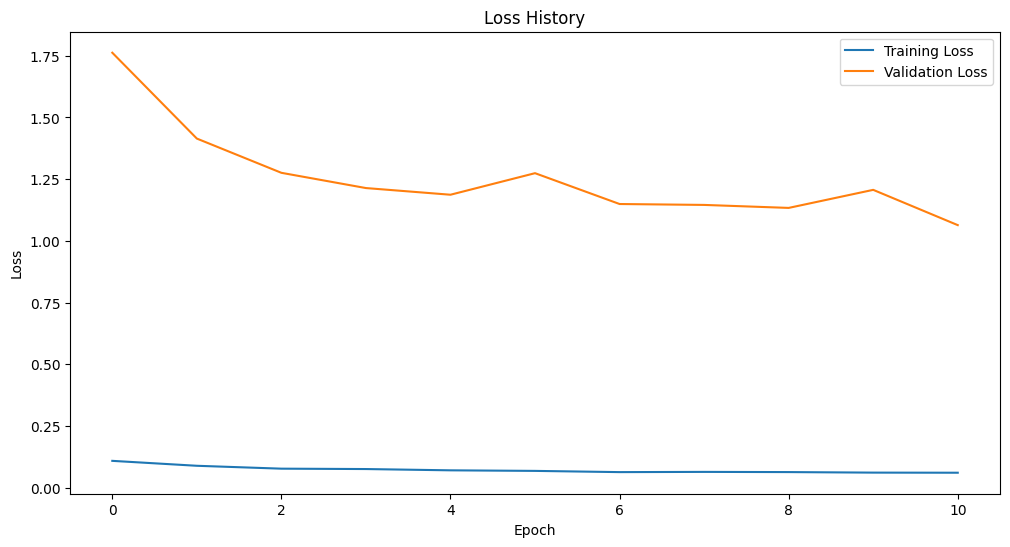

In [15]:
import matplotlib.pyplot as plt
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(loss_history['train'], label='Training Loss')
plt.plot(loss_history['val'], label='Validation Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

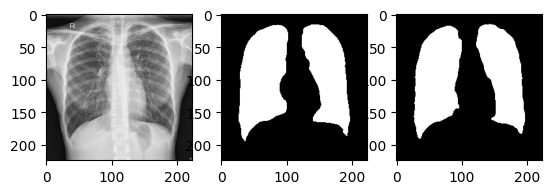

In [13]:
# to visualize the results of medical transformer
my_index = torch.randint(0, len(test_ds),size=(1,)).item()
with torch.no_grad():
    X_test, y_test = test_ds[my_index]
    pred_test = model(X_test.unsqueeze(0).cuda())#.cuda()) uncomment for gpu cuda()
    pred_test = torch.argmax(pred_test, dim=1)
    my_figrue, axarr = plt.subplots(1,3)
    axarr[0].imshow(X_test.cpu().transpose(0,2).transpose(0,1))
    axarr[1].imshow(y_test.cpu(),cmap='gray')
    axarr[2].imshow(pred_test.squeeze(0).cpu(),cmap='gray')

In [16]:
import imageio

# Define the directory to save the masks
SAVE_DIR = '/kaggle/input/custom/medt_results'  # Replace with your actual path
os.makedirs(SAVE_DIR, exist_ok=True)

with torch.no_grad():
    for i in range(10):  # Loop over the first 10 indices
        X_test, y_test = test_ds[i]
        pred_test = model(X_test.unsqueeze(0).cuda())  # .cuda())
        pred_test = torch.argmax(pred_test, dim=1)

        # Save the mask to the directory
        mask_path = os.path.join(SAVE_DIR, f'mask_{i}.png')
        imageio.imsave(mask_path, pred_test.squeeze(0).cpu().numpy())

        my_figure, axarr = plt.subplots(1, 3)
        axarr[0].imshow(X_test.cpu().transpose(0, 2).transpose(0, 1))
        axarr[1].imshow(y_test.cpu(), cmap='gray')
        axarr[2].imshow(pred_test.squeeze(0).cpu(), cmap='gray')

OSError: [Errno 30] Read-only file system: '/kaggle/input/custom/medt_results'

In [14]:
# !pip install GPUtil
# import torch
# from GPUtil import showUtilization as gpu_usage
# from numba import cuda

# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()                             

#     torch.cuda.empty_cache()

#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)

#     print("GPU Usage after emptying the cache")
#     gpu_usage()

# free_gpu_cache()                           
